# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
neer = read_prices("../../Dymon/Code Data/NEER.csv")
neer.columns = [x[0] for x in neer.columns]

In [5]:
g10_neer = neer[[("JBDN"+x+" Index") for x in [x[3:] for x in G10_FX]]]
g10_neer.columns = G10_FX_M

In [6]:
g10_neer_cleaned = g10_neer.pipe(fill_date).pipe(omit_trailing_na)

<AxesSubplot:xlabel='Dates'>

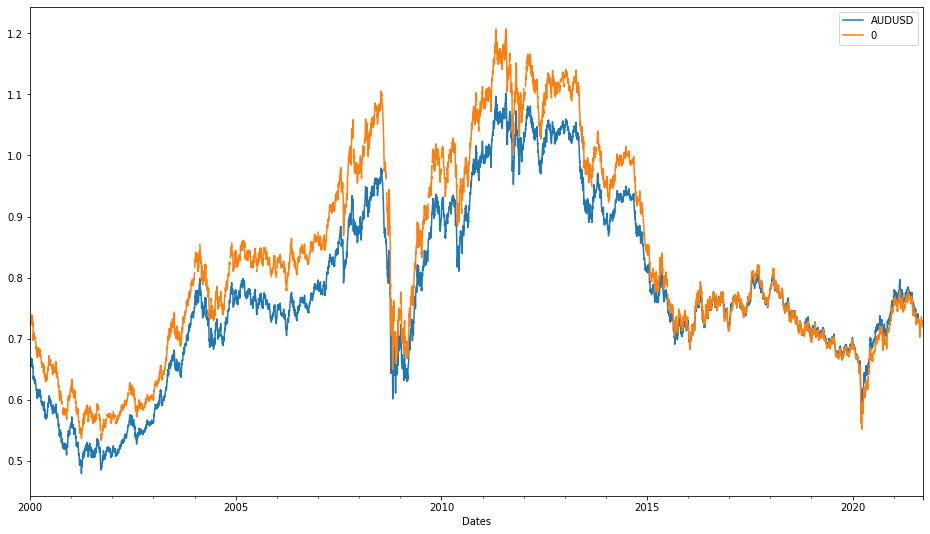

In [33]:
pd.concat([spot_price_ori["AUDUSD"], (g10_neer_cleaned["AUDUSD"]/neer["JBDNUSD Index"].pipe(fill_date).pipe(omit_trailing_na))],axis=1).plot()

<AxesSubplot:xlabel='Dates'>

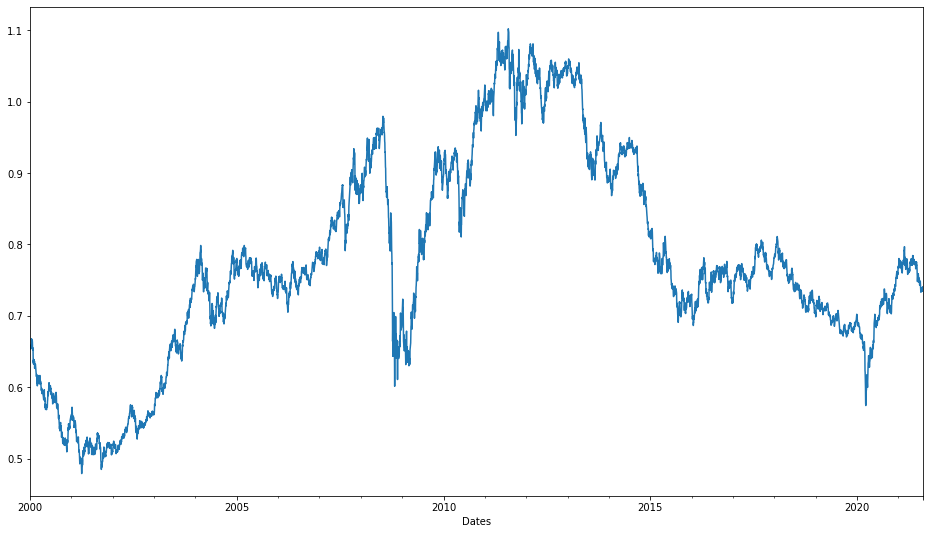

In [23]:
spot_price_ori["AUDUSD"].plot()

<AxesSubplot:xlabel='Dates'>

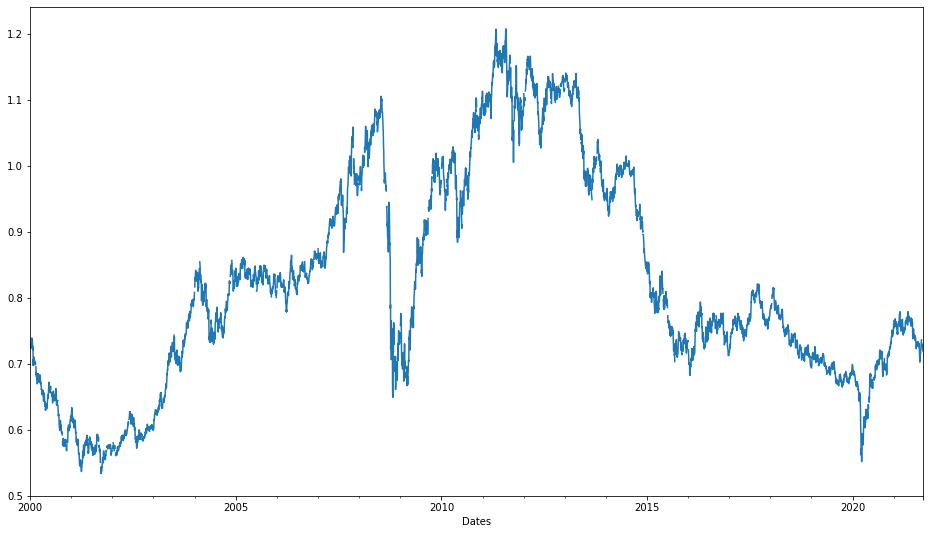

In [27]:
(g10_neer_cleaned["AUDUSD"]/neer["JBDNUSD Index"].pipe(fill_date).pipe(omit_trailing_na)).plot()

# Data integrity

In [7]:
g10_neer.pipe(fill_date).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5665 entries, 2000-01-03 to 2021-09-17
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AUDUSD  5445 non-null   float64
 1   USDCAD  5445 non-null   float64
 2   EURUSD  5445 non-null   float64
 3   GBPUSD  5445 non-null   float64
 4   USDJPY  5445 non-null   float64
 5   NZDUSD  5445 non-null   float64
 6   USDSEK  5445 non-null   float64
 7   USDNOK  5445 non-null   float64
 8   USDCHF  5445 non-null   float64
dtypes: float64(9)
memory usage: 442.6 KB


<AxesSubplot:>

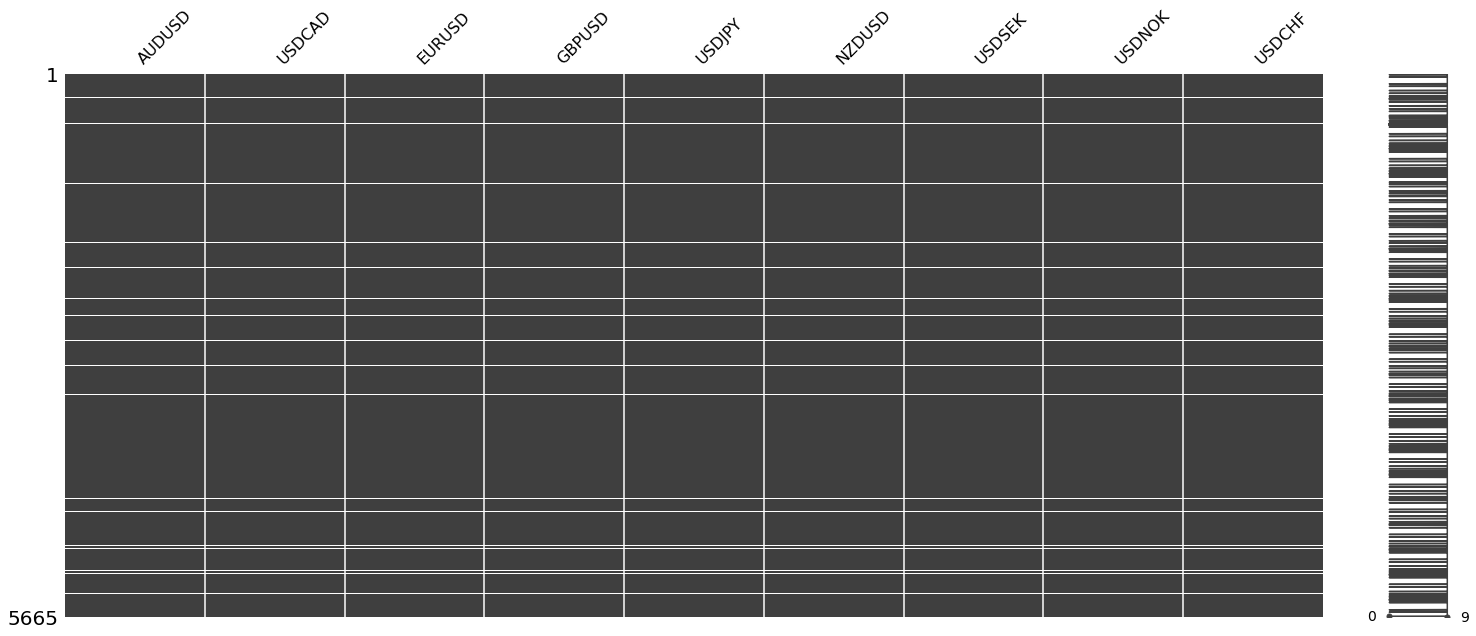

In [8]:
msmx(g10_neer.pipe(fill_date))

# Signal 

In [9]:
def band_filter(series):
  return series.applymap(lambda x: -x if abs(x) > 1.5 else 0)

def hold_until_flip(series):
  ser = pd.DataFrame(series)
  ser.columns = ["ccy"]
  ser["shift"] = ser.shift(1)
  ser["sign_change"] = ser.apply(lambda row: 1 if abs(row["ccy"]) > 1.5 else 0, axis=1)
  ser["sign_change"] = ser.apply(lambda row: 1 if row["sign_change"] == 1 else np.nan if pd.isna(row["ccy"]) else 4 if np.sign(row["ccy"]) != np.sign(row["shift"]) else 0 , axis=1)
  ser["signal"] = ser[["ccy"]].pipe(band_filter)
  ser['sign_forward']=ser['sign_change'].replace(0, np.NaN).ffill()
  ser['sign_shift'] = ser['sign_forward'].diff().replace(0, np.NaN)
  ser["signal"] = ser.apply(lambda row: np.nan if pd.isna(row["sign_shift"]) else row["signal"], axis=1).ffill()
  
  return ser["signal"]

In [10]:
sig = g10_neer_cleaned.pct_change().pipe(standardize_series, "returns").pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1

In [11]:
sig = sig.pipe(demean_xs).pipe(top_bottom_xs)
sig[abs(sig) < 0.25] = 0
sig = CAP(sig, 2.5)

# Backtest Daily Rebal

In [12]:
daily_bt = Backtest(signal = sig, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings,
                    settings_inject={"implementation_lag":1})
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [13]:
get_summary(daily_bt)

Returns   : 0.02101310699151542
Vol       : 0.11000315693994872
SR        : 0.1910227631283944
Max DD    : -32.18

C Returns : 0.015091582670529817
C SR      : 0.16136561434173352
C Max DD  : -27.26

Hit rate  : 0.497
W | N | L : 0.36 | 0.27 | 0.37
W/L Ratio : 0.99


In [14]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.665026,-0.987634,-0.354435,-1.144677,1.044581,-0.677866,2.523436,0.598482,0.014134
sharpe,0.176915,-0.223809,-0.101897,-0.303714,0.233095,-0.172242,0.768413,0.146267,0.003493
dollar_sharpe,0.155903,-0.254792,-0.116013,-0.332035,0.226369,-0.203506,0.768202,0.124564,-0.017054
trade_sharpe,0.461705,-0.535856,1.120537,0.115525,-0.369811,1.004114,0.092882,-0.299568,-0.006468
long_sharpe,1.089927,-0.547411,1.447707,1.104397,-2.148909,1.676695,-0.191335,-0.871879,-0.50578
short_sharpe,0.293318,-0.832691,1.964322,-0.681791,1.021665,1.396134,0.441229,-0.027582,0.936731
sortino,0.05716,-0.076218,-0.031944,-0.077691,0.055794,-0.046801,0.253992,0.043716,0.00101
max_drawdown,-13.676266,-23.906101,-14.248545,-34.587743,-21.219125,-19.612677,-7.048756,-17.084206,-20.819458
max_drawdown_start,2011-05-05,2003-06-10,2015-04-13,2004-03-08,2005-07-21,2003-07-09,2007-02-19,2013-09-05,2010-08-23
max_drawdown_end,2015-06-05,2016-03-10,2016-12-12,2015-11-25,2008-10-08,2011-08-05,2008-10-20,2015-03-17,2011-08-09


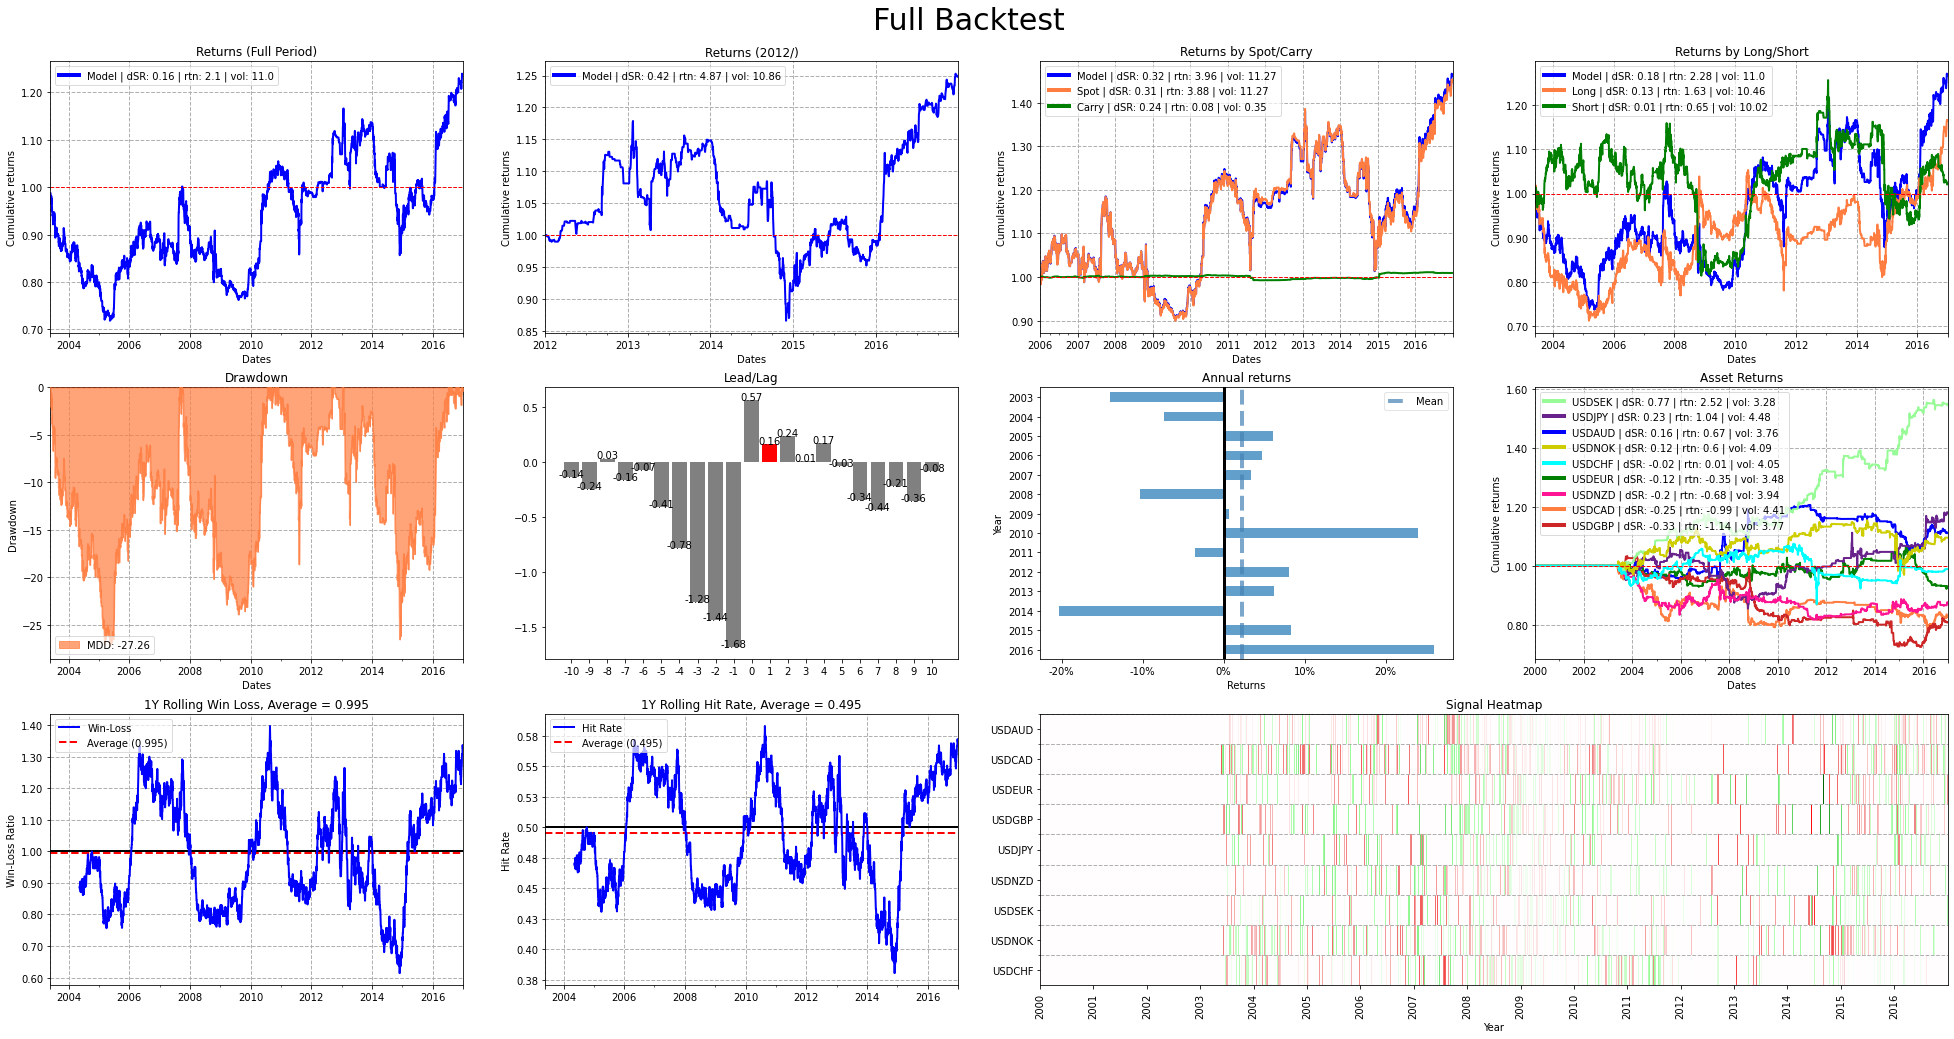

In [15]:
plot_bt(daily_bt)

# Backtest Weekly Rebal

Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


<AxesSubplot:xlabel='Dates', ylabel='Cumulative returns'>

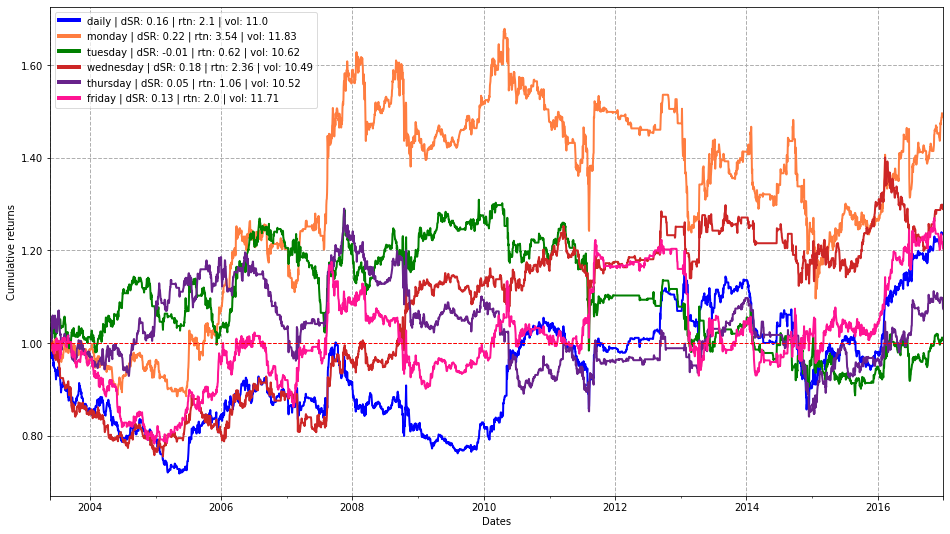

In [41]:
bts = [Backtest(signal = sig, 
             asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings,   
             settings_inject = {"implementation_lag":1, "rebalance_period":t}) for t in ["monday","tuesday", "wednesday",
                                                                 "thursday", "friday"]]
for bt in bts:
  bt.run()
  
gen_plot_rtn(pd.concat([x.model_rtn.rename(x.rebalance_period) for x in [daily_bt]+bts], axis=1))

In [36]:
# pickle.dump(daily_bt, open("../BT/jpm_neer_g10_daily.p", "wb"))
# daily_bt = pickle.load(open("../BT/jpm_neer_g10_daily.p", "rb"))

# pickle.dump(weekly_bt, open("../BT/carry_unwinding_all_weekly.p", "wb"))
# weekly_bt = pickle.load(open("../BT/carry_unwinding_all_weekly.p", "rb"))

# Regime Plot

# Sensitivity Analysis